In [1]:
import os
import pickle

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch

from PIL import Image
from itertools import product

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def to_numpy(t: torch.Tensor):
    """Convert model output from Torch Tensor to numpy array."""

    assert t.ndim == 4

    # Inverse normalize [-1, 1] -> [0, 1], rescale [0, 1] -> [0, 255]
    out = (torch.clamp(t * 0.5 + 0.5, 0, 1) * 255) \
        .permute(0, 2, 3, 1) \
        .detach() \
        .cpu().numpy() \
        .astype(np.uint8)
    return out


def vflip_spatial_weights(state_dict):
    """
    Make a copy of the model weights with any 3 or 4 dimensional weights vertical flipped.
    This was needed because a model trained using StyleGAN2-ada was producing vertically flipped images.
    """

    new_state_dict = deepcopy(state_dict)
    for k, w in new_state_dict.items():
        if w.ndim in [3, 4]:
            new_state_dict[k] = torch.flip(w, dims=[-2])
    return new_state_dict


def load_model(model_pkl_path, device=None):
    """Load StyleGAN2 model from pickle checkpoint file."""

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(model_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
    return G


def generate(G, n=1, z=None):
    """Generate a batch of images using StyleGAN2 generator model."""

    if z is None:
        z = torch.randn([n, G.z_dim]).to(device)    # latent codes
    # class labels (not used in this example)
    c = None

    img = G(z, c)
    img = np.squeeze(to_numpy(img))

    return img


def generate_n_and_save_to_dir(G, outdir, n=5, prefix=""):
    """Generate some amount of images using StyleGAN2 generator model and save them to an output directory."""

    os.makedirs(outdir, exist_ok=True)

    imgs = generate(G, n)
    for img in imgs:
        Image.fromarray(img).save(os.path.join(outdir, f"{prefix}{i}.jpg"))


def get_conv_weights_names(G):
    """Get convolutional layer weights names from StyleGAN2 generator model."""

    state_dict = G.state_dict()

    keys = state_dict.keys()
    keys = [k for k in keys if "conv" in k]
    keys = [k for k in keys if k.endswith(".weight") or k.endswith(".bias")]
    keys = [k for k in keys if "affine" not in k]
    return keys


def blend_2_models(G1, G2,
                   blocks=[
                       "b4",
                       "b8",
                       "b16",
                       "b32",
                       "b64",
                       "b128",
                   ],
                   weights=[
                       0.5,
                       0.5,
                       0.5,
                       0.5,
                       0.5,
                       0.5
                   ],
                   # XXX What to blend? Weights only or both weights and bias?
                   weight_types=["weight",]
                   ):
    """Blend two models by blending their convolutional layer weights."""

    assert len(blocks) == len(weights)

    state_dict_1 = G1.state_dict()
    state_dict_2 = G2.state_dict()
    state_dict_blend = deepcopy(state_dict_1)

    blended_keys = []
    for block, alpha in zip(blocks, weights):
        for i in range(2):
            for wt in weight_types:
                # Get weights name
                if block == "b4" and i == 0:
                    w_name = f"synthesis.{block}.const"
                else:
                    w_name = f"synthesis.{block}.conv{i}.{wt}"

                # If weights name is valid, blend weights from two different model
                if w_name in state_dict_1 and w_name in state_dict_2 \
                        and w_name not in blended_keys:

                    w_model_1 = state_dict_1[w_name]
                    w_model_2 = state_dict_2[w_name]

                    w_blend = alpha * w_model_1 + (1 - alpha) * w_model_2

                    print(f"Blending weights for {w_name}")
                    state_dict_blend[w_name] = w_blend

                    blended_keys.append(w_name)

    return state_dict_blend

In [4]:
G_blend = load_model('./celebahq_128_snapshot_004435.pkl')

In [5]:
# XXX Flip weights
# G.load_state_dict(vflip_spatial_weights(G.state_dict()))
# torch.save(G.state_dict(), "punk_rgb_128_vflip.pth")

In [6]:
G_punk = load_model('punk_rgb_128_augment_factor_5/00000-punk_rgb_128_augment_factor_5-auto1/network-snapshot-003400.pkl')
G_punk.load_state_dict(torch.load("./punk_rgb_128_vflip.pth", map_location="cpu"))

<All keys matched successfully>

In [7]:
G_celebahq = load_model('./celebahq_128_snapshot_004435.pkl')

In [17]:
blended_weights = blend_2_models(G_celebahq, G_punk, weights=[
    1.0,
    1.0,
    1.0,
    0.8,
    0.7,
    0.6,
])
G_blend.load_state_dict(blended_weights)

Blending weights for synthesis.b4.const
Blending weights for synthesis.b4.conv1.weight
Blending weights for synthesis.b8.conv0.weight
Blending weights for synthesis.b8.conv1.weight
Blending weights for synthesis.b16.conv0.weight
Blending weights for synthesis.b16.conv1.weight
Blending weights for synthesis.b32.conv0.weight
Blending weights for synthesis.b32.conv1.weight
Blending weights for synthesis.b64.conv0.weight
Blending weights for synthesis.b64.conv1.weight
Blending weights for synthesis.b128.conv0.weight
Blending weights for synthesis.b128.conv1.weight


<All keys matched successfully>

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/gx/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/gx/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/gx/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/gx/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/home/gx/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directory, is_python_module)
  File "/home/gx/anaconda3/env

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/gx/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/gx/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/gx/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/gx/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/home/gx/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directory, is_python_module)
  File "/home/gx/anaconda3/env

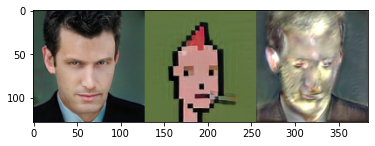

In [19]:
z = torch.randn([1, G_celebahq.z_dim]).to(device)

plt.imshow(
    np.concatenate([
        generate(G_celebahq, 1, z),
        generate(G_punk, 1, z),
        generate(G_blend, 1, z)
    ], axis=1)
)